# Worksheet 4: Creating future climate scenarios and analysing climate change

The following exercises demonstrate basic methods for analysing changes in climate, using two PRECIS experiments (driven by HadCM3Q0 and ECHAM5.) As with worksheets 2 & 3, these are examples of some of the many types of analyses that can be performed using Python and Iris.

<div class="alert alert-block alert-warning">
<b>By the end of this worksheet you should be able to:</b><br> 

- Calculate difference and percentage differences across cubes<br>
- Plot cubes using different plotting methods and with an appropriate colour scale <br>
- Create time series anomalies of precipitation and tempeature<br>
</div>

<div class="alert alert-block alert-info">
<b>Note:</b> As in Worksheet 2a, the data used here has been processed in the same way as in Worksheet 1. The 8-point rim has been removed and it has been converted from PP to netCDF format. </div>

## Contents
### [4.1: Calculate future OND mean precipitation](#4.1) 
### [4.2: Find OND anomalies](#4.2)
### [4.3: Plot precipitation and temperature](#4.3)
### [4.4: Future time series](#4.4)

## Preamble

In [1]:
# Code preamble - these libraries will be used in this worksheet.
# This code block needs to be re-run every time you restart this worksheet!
%matplotlib inline 
import os
import iris
import iris.coord_categorisation
from iris.experimental.equalise_cubes import equalise_attributes
import iris.quickplot as qplt
import iris.plot as iplt
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma

# Some helpful data locations
DATADIR = '/project/precis/worksheets/data'
CLIMDIR = os.path.join(DATADIR, 'climatology')
HISTDIR = os.path.join(DATADIR, 'historical')
FUTRDIR = os.path.join(DATADIR, 'future')
JOBIDS = ['cahpa', 'cahpb']

<a id='4.1'></a>
## 4.1 Calculate future OND mean precipitation
**a)** First, we **calculate future OND (October, November, December) mean precipitation** for the period 2021-2051 for the HadCM3Q0-driven PRECIS simulation (cahpa) and the ECHAM5-driven simulation (cahpb):

In [6]:
for jobid in JOBIDS:
    infile = os.path.join(FUTRDIR, jobid + '.mon.2021_2050.pr.rr.mmday-1.nc')
    data = iris.load_cube(infile)

    # in order to calculate OND mean, we divide the months into two seasons: 
    # one for OND and a second for the remaining months
    iris.coord_categorisation.add_season(data, 'time', name='seasons', seasons=('jfmamjjas','ond'))

    # Extract the data for the OND season only
    data_ond = data.extract(iris.Constraint(seasons='ond'))

    # Now calculate the mean over the OND season
    future_ond_mean = data_ond.aggregated_by(['seasons'], iris.analysis.MEAN)

    # save the OND mean as a netCDF
    outfile = os.path.join(CLIMDIR, jobid + '.OND.mean.2021_2050.pr.mmday-1.nc')
    iris.save(future_ond_mean, outfile)
    print('Saved: {}'.format(outfile))

Saved: /project/precis/worksheets/data/climatology/cahpa.OND.mean.2021_2050.pr.mmday-1.nc
Saved: /project/precis/worksheets/data/climatology/cahpb.OND.mean.2021_2050.pr.mmday-1.nc


---
<div class="alert alert-block alert-success">
<b>Question:</b> Within the loop, we have created two cubes: a seasonal OND constrained cube ("data_ond"), and a seasonal mean cube ("future_ond_mean").  Inspect the cube metadata.  What are the differences? 
</div>

In [7]:
# Use this code block to inspect the two cubes
print (data_ond)
print (future_ond_mean)

precipitation_flux / (mm day-1)     (time: 90; grid_latitude: 192; grid_longitude: 192)
     Dimension coordinates:
          time                           x                  -                    -
          grid_latitude                  -                  x                    -
          grid_longitude                 -                  -                    x
     Auxiliary coordinates:
          seasons                        x                  -                    -
     Attributes:
          Conventions: CF-1.5
          STASH: m01s05i216
          source: Data from Met Office Unified Model
     Cell methods:
          mean: time (1 hour)
precipitation_flux / (mm day-1)     (time: 1; grid_latitude: 192; grid_longitude: 192)
     Dimension coordinates:
          time                           x                 -                    -
          grid_latitude                  -                 x                    -
          grid_longitude                 -                 -        

<b>Answer</b><br>
    *Type your answer here...*

---

Remember, the loop has created and saved two cubes, **one for each jobid**.

<a id='4.2'></a>
## 4.2 Find OND anomalies
**b)** Next, we **subtract the baseline (1961-1990) mean from the future (2021-2050) mean** for OND to get the change in precipitation (or **anomaly**) from both simulations.  The changes are also converted to percentages:

In [8]:
for jobid in JOBIDS:
    # Load the baseline cube
    infile = os.path.join(CLIMDIR, jobid + '.OND.mean.1961_1990.pr.mmday-1.nc')
    OND_baseline = iris.load_cube(infile)
    # Set the correct units
    OND_baseline.units = "mm day-1"
    # Load the future cube
    infile = os.path.join(CLIMDIR, jobid + '.OND.mean.2021_2050.pr.mmday-1.nc')
    OND_future = iris.load_cube(infile)
    # Subtract the baseline cube from the future cube
    diff = iris.analysis.maths.subtract(OND_future, OND_baseline)
    # rename the cube to reflect the data processing
    diff.rename('precipitation flux difference')
    # Save the resulting cube
    outfile = os.path.join(CLIMDIR, jobid + '.OND.mean.diff.pr.mmday-1.nc')
    iris.save(diff, outfile)
    print('Saved {}'.format(outfile))
    # Find the percentage change
    pcent_change = iris.analysis.maths.multiply(iris.analysis.maths.divide(diff, OND_baseline), 100)
    # remember to change the title and units to reflect the data processing
    pcent_change.rename('precipitation flux percent difference')
    pcent_change.units = '%'
    # And save this too
    outfile = os.path.join(CLIMDIR, jobid + '.OND.mean.diffperc.pr.mmday-1.nc')
    iris.save(pcent_change, outfile)
    print('Saved {}'.format(outfile))

Saved /project/precis/worksheets/data/climatology/cahpa.OND.mean.diff.pr.mmday-1.nc
Saved /project/precis/worksheets/data/climatology/cahpa.OND.mean.diffperc.pr.mmday-1.nc
Saved /project/precis/worksheets/data/climatology/cahpb.OND.mean.diff.pr.mmday-1.nc
Saved /project/precis/worksheets/data/climatology/cahpb.OND.mean.diffperc.pr.mmday-1.nc


**c)** Now, repeat the calculations yourself for **temperature**. 

First, we calculate the **OND mean** temperatures. **Fill in the missing commands in the code block below**:

In [12]:
time_periods = {'historical':'1961_1990', 'future':'2021_2050'}

for jobid in JOBIDS:
    for period in time_periods.keys():
        # Load the data:
        infile = os.path.join(DATADIR, period, jobid + '.mon.' + time_periods[period] + '.tm.rr.C.nc')
        data = iris.load_cube(infile)
        
        # In order to calculate OND mean, add a season coordinate, separating OND from the other months:  
        iris.coord_categorisation.add_season(data, 'time', name='seasons', seasons=('jfmamjjas','ond'))

        # Extract the data for the OND season only:
        data_ond = data.extract(iris.Constraint(seasons='ond'))
        
        # Now calculate the mean over the OND season:
        future_ond_mean = data_ond.aggregated_by(['seasons'], iris.analysis.MEAN)

        # save the OND mean as a netCDF ('outfile' specifies the output file name for your OND mean cube):
        outfile = os.path.join(CLIMDIR, jobid + '.OND.mean.' + time_periods[period] + '.tm.C.nc')

        iris.save(future_ond_mean, outfile)
        print('Saved: {}'.format(outfile))
        


Saved: /project/precis/worksheets/data/climatology/cahpa.OND.mean.1961_1990.tm.C.nc
Saved: /project/precis/worksheets/data/climatology/cahpa.OND.mean.2021_2050.tm.C.nc
Saved: /project/precis/worksheets/data/climatology/cahpb.OND.mean.1961_1990.tm.C.nc
Saved: /project/precis/worksheets/data/climatology/cahpb.OND.mean.2021_2050.tm.C.nc


**d)** Next, we **calculate the difference** between the baseline and future periods.

In [13]:
for jobid in JOBIDS:
    # Load files:
    baselinefile = os.path.join(CLIMDIR, jobid + '.OND.mean.1961_1990.tm.C.nc')
    futurefile = os.path.join(CLIMDIR, jobid + '.OND.mean.2021_2050.tm.C.nc')
    OND_baseline = iris.load_cube(baselinefile)
    OND_future = iris.load_cube(futurefile)
    
    # Calculate 'future mean' minus 'baseline mean':
    diff = iris.analysis.maths.subtract(OND_future, OND_baseline)
    diff.rename('surface temperature difference')
    
    # Save
    outfile = os.path.join(CLIMDIR, jobid + '.OND.mean.diff.tm.C.nc')
    iris.save(diff, outfile)
    print('Saved: {}'.format(outfile))

Saved: /project/precis/worksheets/data/climatology/cahpa.OND.mean.diff.tm.C.nc
Saved: /project/precis/worksheets/data/climatology/cahpb.OND.mean.diff.tm.C.nc


<a id='4.3'></a>
## 4.3 Plot precipitation and temperature

**e)** **Plot changes** to precipitation (in %) and temperature (in deg.C)

/opt/scitools/environments/experimental/2018_10_16-1/lib/python3.6/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'grid_longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/opt/scitools/environments/experimental/2018_10_16-1/lib/python3.6/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'grid_latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/opt/scitools/environments/experimental/2018_10_16-1/lib/python3.6/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'grid_longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/opt/scitools/environments/experimental/2018_10_16-1/lib/python3.6/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'grid_latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


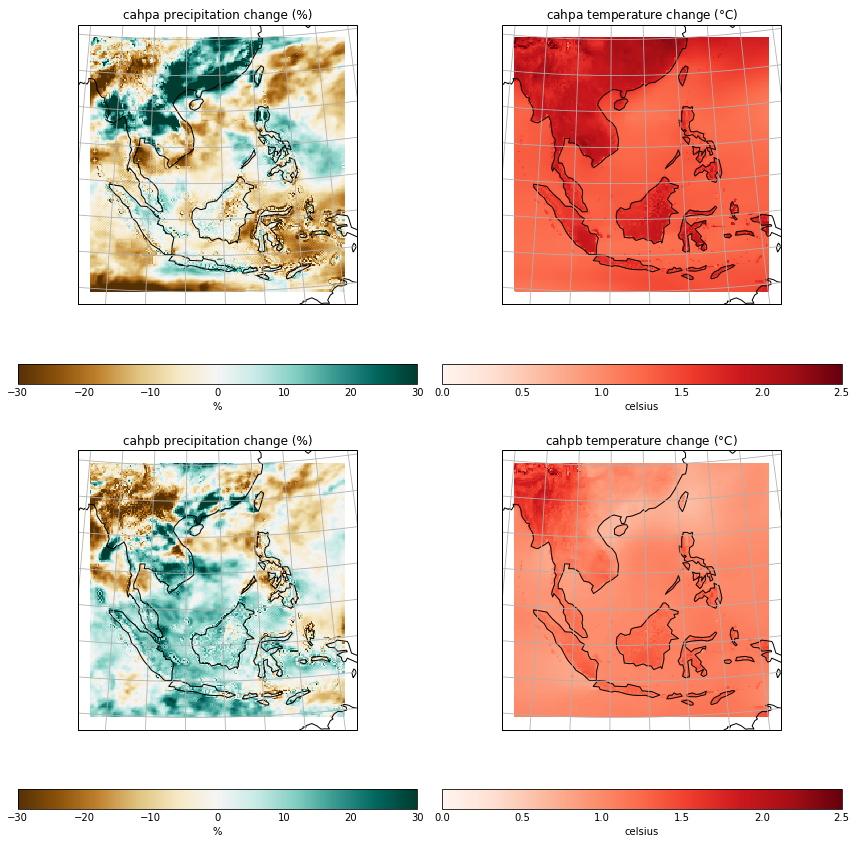

In [14]:
# Create a figure of the size 12x12 inches
plt.figure(figsize=(12, 12))

# Read in the percentage changes in precipitation
for n, jobid in enumerate(JOBIDS):
    prpath = os.path.join(CLIMDIR, jobid + '.OND.mean.diffperc.pr.mmday-1.nc')
    tmpath = os.path.join(CLIMDIR, jobid + '.OND.mean.diff.tm.C.nc')
    pcent_change = iris.load_cube(prpath)
    degc_change = iris.load_cube(tmpath)

    # Remove extra time dimension
    pcent_change = iris.util.squeeze(pcent_change)
    degc_change = iris.util.squeeze(degc_change)
    
    plot_num = n*2 + 1
    plt.subplot(2, 2, plot_num) # Create a new subplot with 2 rows, 2 columns, 1st plot
    qplt.pcolormesh(pcent_change, vmax=30, vmin=-30, cmap='BrBG')
    plt.title(jobid + ' precipitation change (%)')
    ax = plt.gca()              # gca function that returns the current axes
    ax.coastlines()             # adds coastlines defined by the axes of the plot
    ax.gridlines()              # adds x and y grid lines to the plot

    plt.subplot(2, 2, plot_num+1)
    qplt.pcolormesh(degc_change, vmax=2.5, vmin=0, cmap='Reds')
    plt.title(jobid + ' temperature change ($\degree$C)')
    ax = plt.gca()
    ax.coastlines()
    ax.gridlines()

plt.tight_layout()          # automatically adjusts subplot(s) to fit in to the figure area
plt.show()

---
<div class="alert alert-block alert-success">
<b>Question:</b> How would you use a discrete contoured colour map to show changes in precipitation and temperature? <br>
    Modify the code above to use <strong>qplt.pcontourf()</strong>.  Remember to choose appropriate contours.
</div>

<div class="alert alert-block alert-success">
<b>Question:</b>  The plots show projected changes in precipitation and temperature using two models; what are the common features between the two model projections? 
    
What differences exist between the two model projections? Which is hotter, wetter, how does the spatial distribution differ? 
    
</div>

<b>Answer:</b><br>
*Type your answers here...*

---

<a id='4.4'></a>
## 4.4 Future time series

**f)** Calculate and then plot a 2021-2050 monthly **time series of precipitation anomalies** for land
points only, relative to the 1961-1990 baseline monthly mean. Do this for both cahpa and cahpb.


In [15]:
# Read in the land-sea mask. 
# The cube data array has a mask associated with it which we'll use to mask out ocean points.
land_sea_mask = iris.load_cube(DATADIR + '/landmask.nc')

for jobid in JOBIDS:
    # Read in original data for baseline and future
    baselinepath = os.path.join(HISTDIR, jobid + '.mon.1961_1990.pr.rr.mmday-1.nc')
    futurepath = os.path.join(FUTRDIR, jobid + '.mon.2021_2050.pr.rr.mmday-1.nc')
    baseline = iris.load_cube(baselinepath)
    future = iris.load_cube(futurepath)
    
    # Apply land mask
    baseline.data = ma.array(baseline.data, mask=baseline.data*land_sea_mask.data.mask[np.newaxis, :,:])
    future.data = ma.array(future.data, mask=future.data*land_sea_mask.data.mask[np.newaxis, :,:])

    # Guess bounds
    for cube in [baseline, future]:
        for coord in ['grid_longitude', 'grid_latitude']:
            cube.coord(coord).guess_bounds()
    
    # Calculate mean values over land points
    baseline_land = baseline.collapsed(['grid_longitude', 'grid_latitude'], iris.analysis.MEAN,
                                      weights = iris.analysis.cartography.area_weights(baseline))
    future_land = future.collapsed(['grid_longitude', 'grid_latitude'], iris.analysis.MEAN,
                                  weights = iris.analysis.cartography.area_weights(future))

    # Save future & baseline area averaged monthly data (time series)
    baselineout = os.path.join(CLIMDIR, jobid + '.mon.1961_1990.series.pr.mmday-1.nc')
    futureout = os.path.join(CLIMDIR, jobid + '.mon.2021_2050.series.pr.mmday-1.nc')
    iris.save(baseline_land, baselineout)
    iris.save(future_land, futureout)

    # Subtract baseline from future
    diff = future_land.copy()
    diff.data = future_land.data - baseline_land.data.mean()
    diff.rename('future anomaly relative to mean historical precipitation')

    # Save the area averaged monthly future anomalies (time series)
    outpath = os.path.join(CLIMDIR, jobid + '.mon.2021_2050.anom.series.pr.mmday-1.nc')
    iris.save(diff, outpath)
    print('Saved: {}'.format(outpath))

Saved: /project/precis/worksheets/data/climatology/cahpa.mon.2021_2050.anom.series.pr.mmday-1.nc
Saved: /project/precis/worksheets/data/climatology/cahpb.mon.2021_2050.anom.series.pr.mmday-1.nc


---
<div class="alert alert-block alert-success">
    <b>Question:</b> Why do we only want to produce a time series for changes over land?
</div>

**Answer:**

_Type your answer here..._

---

**g)** **Plot the precipitation anomalies** of cahpa and cahpb

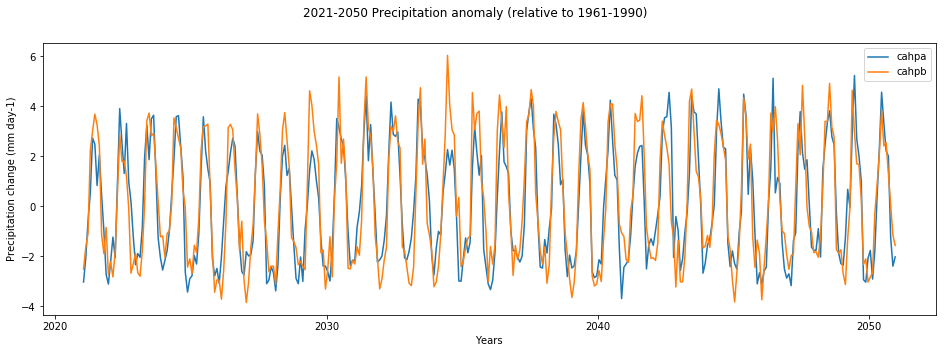

In [16]:
# Read in the monthly series
cahpa = iris.load_cube(CLIMDIR + '/cahpa.mon.2021_2050.anom.series.pr.mmday-1.nc')
cahpb = iris.load_cube(CLIMDIR + '/cahpb.mon.2021_2050.anom.series.pr.mmday-1.nc')
time = cahpa.coord('time')

# Plot the two model time series' on the same figure
plt.figure(figsize=(16,5))
iplt.plot(time, cahpa, label = 'cahpa')
iplt.plot(time, cahpb, label = 'cahpb')
plt.legend()
plt.suptitle('2021-2050 Precipitation anomaly (relative to 1961-1990)')
plt.ylabel('Precipitation change ({})'.format(cahpa.units))
plt.xlabel('Years')
plt.show()

**h) Produce and plot a montly time series of temperature data** relative to the 1961-1990 baseline.  As for (f) and (g) produce time series for cahpa and cahpb.

**Fill in the missing commands in the code blocks below**:

In [19]:
# Loop over JOBIDS
for jobid in JOBIDS:

# Read in original data for baseline and future
    baselinepath = os.path.join(HISTDIR, jobid + '.mon.1961_1990.tm.rr.C.nc')
    futurepath = os.path.join(FUTRDIR, jobid + '.mon.2021_2050.tm.rr.C.nc')
    baseline = iris.load_cube(baselinepath)
    future = iris.load_cube(futurepath)

# Apply land mask
    baseline.data = ma.array(baseline.data, mask=baseline.data*land_sea_mask.data.mask[np.newaxis, :,:])
    future.data = ma.array(future.data, mask=future.data*land_sea_mask.data.mask[np.newaxis, :,:])

# Guess bounds
    for cube in [baseline, future]:
        for coord in ['grid_longitude', 'grid_latitude']:
            cube.coord(coord).guess_bounds()

# Calculate mean values over land points
    baseline_land = baseline.collapsed(['grid_longitude', 'grid_latitude'], iris.analysis.MEAN,
                                      weights = iris.analysis.cartography.area_weights(baseline))
    future_land = future.collapsed(['grid_longitude', 'grid_latitude'], iris.analysis.MEAN,
                                  weights = iris.analysis.cartography.area_weights(future))

# Save future & baseline area averaged monthly data (time series)
    baselineout = os.path.join(CLIMDIR, jobid + '.mon.1961_1990.series.tm.rr.C.nc')
    futureout = os.path.join(CLIMDIR, jobid + '.mon.2021_2050.series.tm.rr.C.nc')
    iris.save(baseline_land, baselineout)
    iris.save(future_land, futureout)    

# Subtract baseline from future    
    diff = future_land.copy()
    diff.data = future_land.data - baseline_land.data.mean()
    diff.rename('future anomaly relative to mean historical temperature')
    
# Save the data, make sure you follow the file naming convention!
    outpath = os.path.join(CLIMDIR, jobid + '.mon.2021_2050.anom.series.tm.rr.C.nc')
    iris.save(diff, outpath)
    print('Saved: {}'.format(outpath))


Saved: /project/precis/worksheets/data/climatology/cahpa.mon.2021_2050.anom.series.tm.rr.C.nc
Saved: /project/precis/worksheets/data/climatology/cahpb.mon.2021_2050.anom.series.tm.rr.C.nc


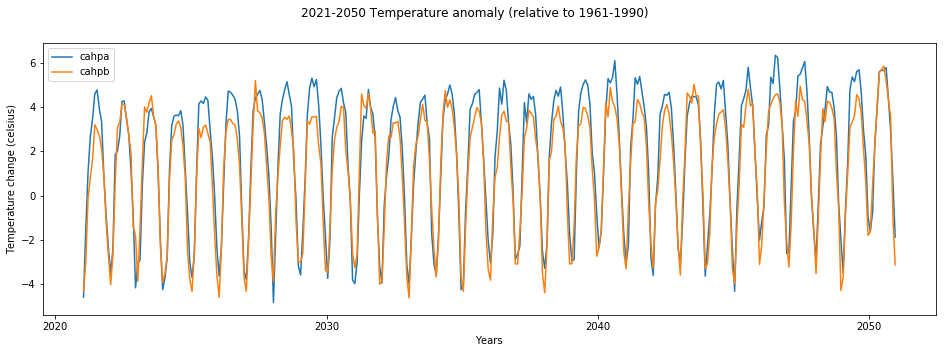

In [20]:
# Do some plotting...
# Read in the monthly series
cahpa = iris.load_cube(CLIMDIR + '/cahpa.mon.2021_2050.anom.series.tm.rr.C.nc')
cahpb = iris.load_cube(CLIMDIR + '/cahpb.mon.2021_2050.anom.series.tm.rr.C.nc')
time = cahpa.coord('time')

# Plot the two model time series' on the same figure
plt.figure(figsize=(16,5))
iplt.plot(time, cahpa, label = 'cahpa')
iplt.plot(time, cahpb, label = 'cahpb')
plt.legend()
plt.suptitle('2021-2050 Temperature anomaly (relative to 1961-1990)')
plt.ylabel('Temperature change ({})'.format(cahpa.units))
plt.xlabel('Years')
plt.show()



---
<div class="alert alert-block alert-success">
<b>Question:</b> Write a short summary of these two graphs. Include:
        
- A description of what each plot shows
- The differences between the two models
- A consideration of the ways the climate in SE Asia might be different in the future
</div>

**Answer:**

_Type your answer here..._

<div class="alert alert-block alert-success">
    <b>Question:</b> Conside the plots we produced in Section 4.3.  What <b>additional</b> time series analysis could you do to support your consideration of future changes to climate in the question above?
</div>

---

<div class="alert alert-block alert-warning">
<center><b>This completes worksheet 4.</b></center><br>
    You have used Iris to investigate differences between historical and future changes in model output by comparing 30 years of baseline data (1961-1990) against a future period (2021-2050). <br>
To do so, you have:
    
- calculated and plotted seasonal mean changes in temperature and precipitation
- masked out ocean data to focus on changes over land
- calculated anomalies by comparing future data to the historical mean period
- plotted time series of both temperature and precipitation anomalies over land for two different models<br>

In worksheet 5, you will investigate climate extremes by investigating threshold and extreme climate indicies.
</div>

<center>© Crown Copyright 2019, Met Office </center>